<a href="https://colab.research.google.com/github/bfacesar/Atividade_III_Cesar/blob/main/Part%201%20-%20CNNs/06%20-%20Improving%20the%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
# # Transformação: converte para tensor e normaliza (média e desvio de MNIST)
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
# ])

# # Dataset de treino e teste
# train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# # Subset com os primeiros 1000 para treino e 500 para validação
# train_subset = Subset(train_dataset, range(1000))
# val_subset   = Subset(test_dataset, range(500))

# # DataLoaders
# train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
# val_loader   = DataLoader(val_subset, batch_size=64, shuffle=False)

In [3]:
# Transformação padrão para Fashion-MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

# Dataset Fashion-MNIST
full_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
full_val_dataset   = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Subsets reduzidos
train_subset = Subset(full_train_dataset, range(200))
val_subset   = Subset(full_val_dataset, range(200))

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=64, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 308kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.61MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.38MB/s]


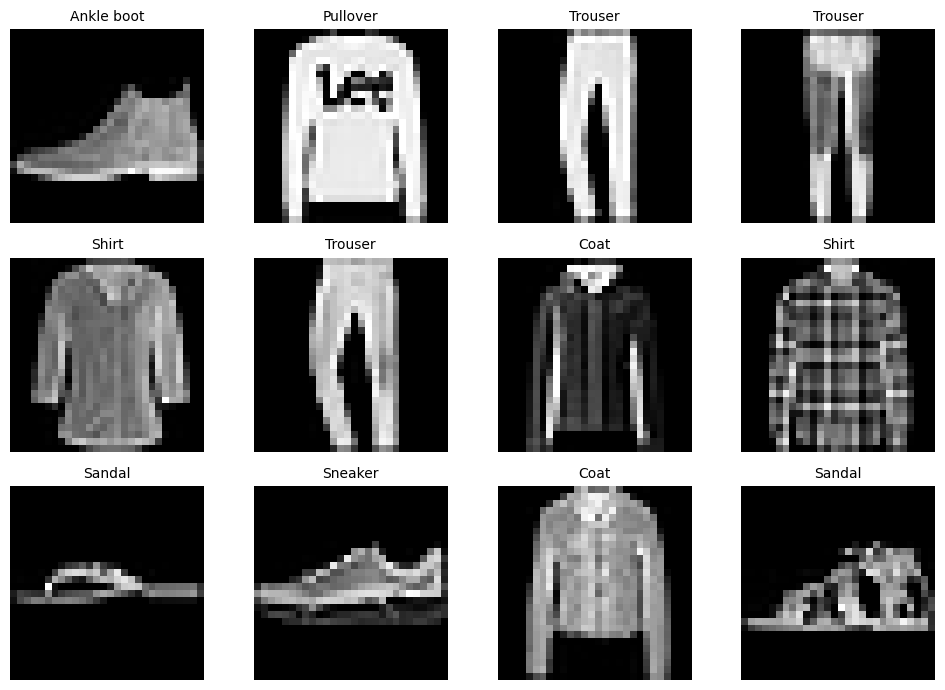

In [4]:
# Classe names
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Mostrar 12 imagens
fig, axes = plt.subplots(3, 4, figsize=(10, 7))
for i, ax in enumerate(axes.flatten()):
    img, label = val_subset[i]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(class_names[label], fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [5]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')


def plot_training_history(history):
    epochs = range(1, len(history['train_losses']) + 1)

    plt.figure(figsize=(12, 5))

    # Losses
    plt.subplot(1, 2, 1)
    plt.grid()
    plt.plot(epochs, history['train_losses'], label='Train Loss')
    plt.plot(epochs, history['val_losses'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracies
    plt.subplot(1, 2, 2)
    plt.grid()
    plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [6]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

100%|██████████| 4/4 [00:00<00:00,  9.58it/s]


Epoch 1, Train Loss: 2.310, Train Accuracy: 9.00%
Epoch 1, Val Loss: 2.308, Val Accuracy: 7.50%


100%|██████████| 4/4 [00:00<00:00, 28.47it/s]


Epoch 2, Train Loss: 2.310, Train Accuracy: 9.00%
Epoch 2, Val Loss: 2.295, Val Accuracy: 10.50%


100%|██████████| 4/4 [00:00<00:00, 53.05it/s]


Epoch 3, Train Loss: 2.294, Train Accuracy: 10.00%
Epoch 3, Val Loss: 2.278, Val Accuracy: 12.00%


100%|██████████| 4/4 [00:00<00:00, 51.21it/s]


Epoch 4, Train Loss: 2.264, Train Accuracy: 22.50%
Epoch 4, Val Loss: 2.258, Val Accuracy: 27.50%


100%|██████████| 4/4 [00:00<00:00, 53.52it/s]


Epoch 5, Train Loss: 2.254, Train Accuracy: 29.50%
Epoch 5, Val Loss: 2.233, Val Accuracy: 24.00%


100%|██████████| 4/4 [00:00<00:00, 52.83it/s]


Epoch 6, Train Loss: 2.191, Train Accuracy: 29.00%
Epoch 6, Val Loss: 2.196, Val Accuracy: 22.00%


100%|██████████| 4/4 [00:00<00:00, 52.51it/s]


Epoch 7, Train Loss: 2.203, Train Accuracy: 22.00%
Epoch 7, Val Loss: 2.135, Val Accuracy: 19.00%


100%|██████████| 4/4 [00:00<00:00, 54.27it/s]


Epoch 8, Train Loss: 2.082, Train Accuracy: 18.50%
Epoch 8, Val Loss: 2.068, Val Accuracy: 18.50%


100%|██████████| 4/4 [00:00<00:00, 41.56it/s]


Epoch 9, Train Loss: 2.065, Train Accuracy: 17.00%
Epoch 9, Val Loss: 1.988, Val Accuracy: 19.00%


100%|██████████| 4/4 [00:00<00:00, 54.63it/s]


Epoch 10, Train Loss: 1.970, Train Accuracy: 20.00%
Epoch 10, Val Loss: 1.891, Val Accuracy: 25.50%


100%|██████████| 4/4 [00:00<00:00, 53.06it/s]


Epoch 11, Train Loss: 1.813, Train Accuracy: 34.50%
Epoch 11, Val Loss: 1.797, Val Accuracy: 38.50%


100%|██████████| 4/4 [00:00<00:00, 50.36it/s]


Epoch 12, Train Loss: 1.689, Train Accuracy: 45.00%
Epoch 12, Val Loss: 1.629, Val Accuracy: 39.50%


100%|██████████| 4/4 [00:00<00:00, 45.97it/s]


Epoch 13, Train Loss: 1.420, Train Accuracy: 45.00%
Epoch 13, Val Loss: 1.532, Val Accuracy: 42.50%


100%|██████████| 4/4 [00:00<00:00, 53.82it/s]


Epoch 14, Train Loss: 1.285, Train Accuracy: 47.50%
Epoch 14, Val Loss: 1.364, Val Accuracy: 53.50%


100%|██████████| 4/4 [00:00<00:00, 52.61it/s]


Epoch 15, Train Loss: 1.184, Train Accuracy: 58.50%
Epoch 15, Val Loss: 1.120, Val Accuracy: 63.00%


100%|██████████| 4/4 [00:00<00:00, 48.19it/s]


Epoch 16, Train Loss: 1.031, Train Accuracy: 62.50%
Epoch 16, Val Loss: 1.050, Val Accuracy: 62.00%


100%|██████████| 4/4 [00:00<00:00, 55.09it/s]


Epoch 17, Train Loss: 0.899, Train Accuracy: 69.50%
Epoch 17, Val Loss: 0.962, Val Accuracy: 62.00%


100%|██████████| 4/4 [00:00<00:00, 53.17it/s]


Epoch 18, Train Loss: 0.799, Train Accuracy: 71.00%
Epoch 18, Val Loss: 0.889, Val Accuracy: 64.00%


100%|██████████| 4/4 [00:00<00:00, 52.76it/s]


Epoch 19, Train Loss: 0.944, Train Accuracy: 70.00%
Epoch 19, Val Loss: 0.851, Val Accuracy: 69.00%


100%|██████████| 4/4 [00:00<00:00, 51.46it/s]


Epoch 20, Train Loss: 0.937, Train Accuracy: 69.50%
Epoch 20, Val Loss: 1.138, Val Accuracy: 58.50%
Treinamento concluído


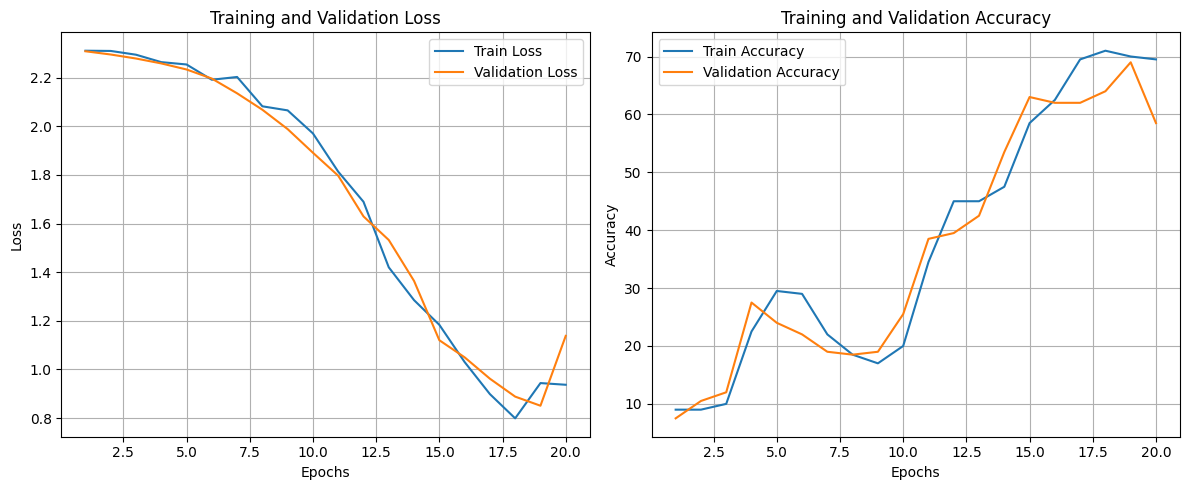

Acurácia da rede na base de teste: 58.50%


In [7]:
model_1 = CNN(
    initialize_weights=False,
    dropout=0.0
)

criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9)

# Treinando a CNN
history_1 = train_model(
    model=model_1,
    trainloader=train_loader,
    valloader=val_loader,
    criterion=criterion_1,
    optimizer=optimizer_1,
    num_epochs=20
)

plot_training_history(history_1)

test_model(model_1, val_loader)

100%|██████████| 4/4 [00:00<00:00, 46.14it/s]


Epoch 1, Train Loss: 2.473, Train Accuracy: 9.00%
Epoch 1, Val Loss: 2.297, Val Accuracy: 7.00%


100%|██████████| 4/4 [00:00<00:00, 48.28it/s]


Epoch 2, Train Loss: 2.288, Train Accuracy: 10.50%
Epoch 2, Val Loss: 2.281, Val Accuracy: 15.00%


100%|██████████| 4/4 [00:00<00:00, 48.06it/s]


Epoch 3, Train Loss: 2.270, Train Accuracy: 15.50%
Epoch 3, Val Loss: 2.257, Val Accuracy: 19.00%


100%|██████████| 4/4 [00:00<00:00, 46.08it/s]


Epoch 4, Train Loss: 2.269, Train Accuracy: 19.50%
Epoch 4, Val Loss: 2.206, Val Accuracy: 26.50%


100%|██████████| 4/4 [00:00<00:00, 45.63it/s]


Epoch 5, Train Loss: 2.184, Train Accuracy: 22.00%
Epoch 5, Val Loss: 2.139, Val Accuracy: 27.50%


100%|██████████| 4/4 [00:00<00:00, 44.26it/s]


Epoch 6, Train Loss: 2.122, Train Accuracy: 21.00%
Epoch 6, Val Loss: 2.037, Val Accuracy: 33.00%


100%|██████████| 4/4 [00:00<00:00, 53.41it/s]


Epoch 7, Train Loss: 2.014, Train Accuracy: 29.00%
Epoch 7, Val Loss: 1.921, Val Accuracy: 35.00%


100%|██████████| 4/4 [00:00<00:00, 51.65it/s]


Epoch 8, Train Loss: 1.934, Train Accuracy: 29.50%
Epoch 8, Val Loss: 1.805, Val Accuracy: 39.50%


100%|██████████| 4/4 [00:00<00:00, 32.44it/s]


Epoch 9, Train Loss: 1.820, Train Accuracy: 34.50%
Epoch 9, Val Loss: 1.712, Val Accuracy: 43.00%


100%|██████████| 4/4 [00:00<00:00, 28.53it/s]

Epoch 10, Train Loss: 1.575, Train Accuracy: 38.00%


Epoch 10, Val Loss: 1.590, Val Accuracy: 46.50%


100%|██████████| 4/4 [00:00<00:00, 37.83it/s]


Epoch 11, Train Loss: 1.583, Train Accuracy: 49.00%
Epoch 11, Val Loss: 1.497, Val Accuracy: 52.00%


100%|██████████| 4/4 [00:00<00:00, 35.03it/s]


Epoch 12, Train Loss: 1.528, Train Accuracy: 51.50%
Epoch 12, Val Loss: 1.475, Val Accuracy: 54.50%


100%|██████████| 4/4 [00:00<00:00, 33.78it/s]


Epoch 13, Train Loss: 1.356, Train Accuracy: 52.50%
Epoch 13, Val Loss: 1.303, Val Accuracy: 57.00%


100%|██████████| 4/4 [00:00<00:00, 35.61it/s]


Epoch 14, Train Loss: 1.292, Train Accuracy: 52.00%
Epoch 14, Val Loss: 1.217, Val Accuracy: 58.50%


100%|██████████| 4/4 [00:00<00:00, 36.66it/s]


Epoch 15, Train Loss: 1.084, Train Accuracy: 60.00%
Epoch 15, Val Loss: 1.175, Val Accuracy: 57.50%


100%|██████████| 4/4 [00:00<00:00, 33.15it/s]


Epoch 16, Train Loss: 1.140, Train Accuracy: 63.50%
Epoch 16, Val Loss: 1.119, Val Accuracy: 59.00%


100%|██████████| 4/4 [00:00<00:00, 34.88it/s]


Epoch 17, Train Loss: 1.090, Train Accuracy: 64.00%
Epoch 17, Val Loss: 0.992, Val Accuracy: 64.50%


100%|██████████| 4/4 [00:00<00:00, 33.82it/s]


Epoch 18, Train Loss: 0.977, Train Accuracy: 68.00%
Epoch 18, Val Loss: 0.922, Val Accuracy: 69.50%


100%|██████████| 4/4 [00:00<00:00, 33.85it/s]


Epoch 19, Train Loss: 0.954, Train Accuracy: 68.00%
Epoch 19, Val Loss: 0.932, Val Accuracy: 68.50%


100%|██████████| 4/4 [00:00<00:00, 31.48it/s]

Epoch 20, Train Loss: 0.766, Train Accuracy: 73.50%


Epoch 20, Val Loss: 0.944, Val Accuracy: 69.50%
Treinamento concluído


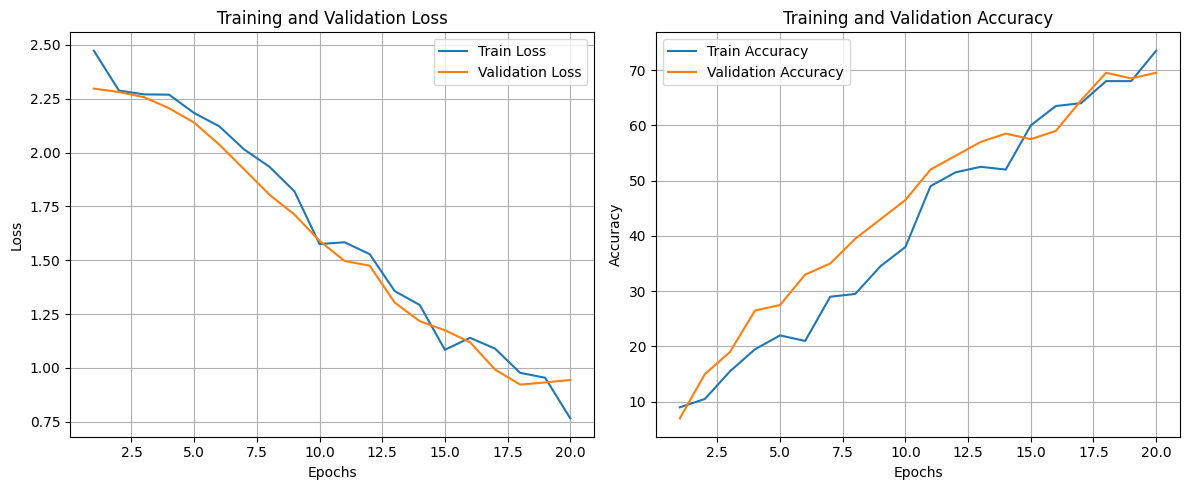

Acurácia da rede na base de teste: 69.50%


In [8]:
model_2 = CNN(
    initialize_weights=True,
    dropout=0.5
)

criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9)

# Treinando a CNN
history_2 = train_model(
    model=model_2,
    trainloader=train_loader,
    valloader=val_loader,
    criterion=criterion_2,
    optimizer=optimizer_2,
    num_epochs=20
)

plot_training_history(history_2)

test_model(model_2, val_loader)

## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

In [10]:
# Exercício 1 (CORRIGIDO para rodar mesmo se as variáveis não existirem ainda)
# O erro aconteceu porque, no seu Colab, ainda não existiam:
# - device
# - train_loader_small
# - val_loader_small
# - test_loader
#
# Este bloco cria/define tudo isso (device + loaders) e então executa os 4 experimentos:
# conv1 in {6,8} e conv2 in {12,16}, avaliando o melhor no TESTE.

import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# -----------------------------
# Reprodutibilidade (opcional)
# -----------------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# -----------------------------
# Device (CPU/GPU)
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============================================================
# Criar datasets/loaders (FashionMNIST)
# Mesma normalização usada no notebook:
# mean=0.2860, std=0.3530
# Subsets pequenos: 200 treino / 200 validação (como no notebook)
# ============================================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

train_dataset_full = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_subset = Subset(train_dataset_full, range(200))
val_subset = Subset(train_dataset_full, range(200, 400))  # validação diferente do treino

train_loader_small = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader_small = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ============================================================
# Funções de treino/val/test (auto-contidas)
# (para não depender das funções do notebook)
# ============================================================
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    """
    Treina o modelo e avalia no conjunto de validação ao final de cada época.
    Retorna histórico básico (loss/acc treino e loss/acc validação).
    """
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        # ----- Treino -----
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # ----- Validação -----
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)

                val_running_loss += loss.item() * x.size(0)
                preds = logits.argmax(dim=1)
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)

        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Log simples por época
        print(
            f"Epoch [{epoch+1:02d}/{num_epochs}] "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
        )

    return history


def test_model(model, test_loader):
    """
    Avalia e retorna acurácia no conjunto de teste.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


# ============================================================
# CNN parametrizável (conv1/conv2)
# ============================================================
class CNN(nn.Module):
    def __init__(self, c1=6, c2=12):
        """
        c1: nº de filtros na conv1 (6 ou 8)
        c2: nº de filtros na conv2 (12 ou 16)
        """
        super().__init__()
        self.conv1 = nn.Conv2d(1, c1, kernel_size=5)
        self.conv2 = nn.Conv2d(c1, c2, kernel_size=5)

        # Flatten final: c2 * 4 * 4 (devido ao shape 4x4 após conv/pool)
        self.fc1 = nn.Linear(c2 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# ============================================================
# Experimentos solicitados:
# conv1: 6 e 8
# conv2: 12 e 16
# Melhor combinação = maior acurácia no TESTE
# ============================================================
criterion = nn.CrossEntropyLoss()
conv1_options = [6, 8]
conv2_options = [12, 16]

results = []

for c1 in conv1_options:
    for c2 in conv2_options:
        print("\n" + "=" * 60)
        print(f"Treinando modelo com conv1={c1} filtros e conv2={c2} filtros")

        set_seed(42)

        model = CNN(c1=c1, c2=c2).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

        _ = train_model(
            model,
            train_loader_small,
            val_loader_small,
            criterion,
            optimizer,
            num_epochs=20
        )

        test_acc = test_model(model, test_loader)
        print(f"==> Test Acc (conv1={c1}, conv2={c2}): {test_acc:.4f}")

        results.append({
            "conv1_filters": c1,
            "conv2_filters": c2,
            "test_acc": float(test_acc)
        })

# Ordena e imprime resumo final
results_sorted = sorted(results, key=lambda x: x["test_acc"], reverse=True)

print("\n" + "=" * 60)
print("=== Resultados no TESTE (ordenados do melhor para o pior) ===")
for r in results_sorted:
    print(f"conv1={r['conv1_filters']}, conv2={r['conv2_filters']} -> test_acc={r['test_acc']:.4f}")

best = results_sorted[0]
print("\n=== Melhor combinação ===")
print(f"conv1={best['conv1_filters']}, conv2={best['conv2_filters']} -> test_acc={best['test_acc']:.4f}")


Device: cpu

Treinando modelo com conv1=6 filtros e conv2=12 filtros
Epoch [01/20] Train Loss: 2.2932 | Train Acc: 0.1700 Val Loss: 2.2896 | Val Acc: 0.1600
Epoch [02/20] Train Loss: 2.2520 | Train Acc: 0.2550 Val Loss: 2.2425 | Val Acc: 0.2150
Epoch [03/20] Train Loss: 2.1795 | Train Acc: 0.2900 Val Loss: 2.1469 | Val Acc: 0.2600
Epoch [04/20] Train Loss: 1.9947 | Train Acc: 0.3550 Val Loss: 1.8704 | Val Acc: 0.3600
Epoch [05/20] Train Loss: 1.5899 | Train Acc: 0.4900 Val Loss: 1.4454 | Val Acc: 0.4950
Epoch [06/20] Train Loss: 1.2434 | Train Acc: 0.5850 Val Loss: 1.4789 | Val Acc: 0.4350
Epoch [07/20] Train Loss: 1.1996 | Train Acc: 0.5950 Val Loss: 1.4891 | Val Acc: 0.4850
Epoch [08/20] Train Loss: 1.0774 | Train Acc: 0.5800 Val Loss: 1.3533 | Val Acc: 0.4700
Epoch [09/20] Train Loss: 0.9679 | Train Acc: 0.6600 Val Loss: 1.1757 | Val Acc: 0.5300
Epoch [10/20] Train Loss: 0.8019 | Train Acc: 0.6900 Val Loss: 1.2722 | Val Acc: 0.5250
Epoch [11/20] Train Loss: 0.8101 | Train Acc: 0.685

### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [11]:
# ============================================================
# ============================================================

import random
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# Reprodutibilidade
# -----------------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ============================================================
# CNN parametrizável no nº de neurônios do fc1
# ============================================================
class CNN(nn.Module):
    def __init__(self, fc1_neurons=64, c1=6, c2=12):
        """
        fc1_neurons: nº de neurônios da camada fc1 (variável neste exercício)
        c1, c2: filtros convolucionais (mantidos fixos)
        """
        super().__init__()

        self.conv1 = nn.Conv2d(1, c1, kernel_size=5)
        self.conv2 = nn.Conv2d(c1, c2, kernel_size=5)

        # Flatten final: c2 * 4 * 4
        self.fc1 = nn.Linear(c2 * 4 * 4, fc1_neurons)

        # A entrada do fc2 DEPENDE do fc1_neurons
        self.fc2 = nn.Linear(fc1_neurons, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# ============================================================
# Sorteio aleatório dos 5 valores de fc1
# ============================================================
num_experiments = 5
fc1_candidates = random.sample(range(32, 257), num_experiments)
print("Valores sorteados para fc1:", fc1_candidates)

criterion = nn.CrossEntropyLoss()
results = []

# ============================================================
# Execução dos 5 treinamentos
# ============================================================
for fc1_units in fc1_candidates:
    print("\n" + "=" * 60)
    print(f"Treinando modelo com fc1 = {fc1_units} neurônios")

    set_seed(42)

    model = CNN(fc1_neurons=fc1_units).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    _ = train_model(
        model,
        train_loader_small,
        val_loader_small,
        criterion,
        optimizer,
        num_epochs=20
    )

    test_acc = test_model(model, test_loader)
    print(f"==> Test Acc (fc1={fc1_units}): {test_acc:.4f}")

    results.append({
        "fc1_neurons": fc1_units,
        "test_acc": float(test_acc)
    })

# ============================================================
# Análise final
# ============================================================
results_sorted = sorted(results, key=lambda x: x["test_acc"], reverse=True)

print("\n" + "=" * 60)
print("=== Resultados no TESTE (ordenados do melhor para o pior) ===")
for r in results_sorted:
    print(f"fc1={r['fc1_neurons']} -> test_acc={r['test_acc']:.4f}")

best = results_sorted[0]
print("\n=== Melhor valor de fc1 ===")
print(f"fc1={best['fc1_neurons']} neurônios -> test_acc={best['test_acc']:.4f}")

# ============================================================
# "Como determinar o melhor valor?"
#   Comparando a acurácia no conjunto de TESTE.
#   O melhor valor é aquele que maximiza o desempenho
#   sem introduzir overfitting.
# ============================================================


Valores sorteados para fc1: [195, 60, 38, 221, 102]

Treinando modelo com fc1 = 195 neurônios
Epoch [01/20] Train Loss: 2.3055 | Train Acc: 0.0850 Val Loss: 2.2782 | Val Acc: 0.2350
Epoch [02/20] Train Loss: 2.2408 | Train Acc: 0.2550 Val Loss: 2.2138 | Val Acc: 0.1550
Epoch [03/20] Train Loss: 2.1166 | Train Acc: 0.2350 Val Loss: 2.0383 | Val Acc: 0.2500
Epoch [04/20] Train Loss: 1.7722 | Train Acc: 0.4800 Val Loss: 1.6079 | Val Acc: 0.4500
Epoch [05/20] Train Loss: 1.3755 | Train Acc: 0.5000 Val Loss: 1.5782 | Val Acc: 0.4600
Epoch [06/20] Train Loss: 1.3380 | Train Acc: 0.5400 Val Loss: 1.7543 | Val Acc: 0.4600
Epoch [07/20] Train Loss: 1.1701 | Train Acc: 0.6150 Val Loss: 1.3029 | Val Acc: 0.5600
Epoch [08/20] Train Loss: 0.9901 | Train Acc: 0.6800 Val Loss: 1.1929 | Val Acc: 0.5950
Epoch [09/20] Train Loss: 0.8184 | Train Acc: 0.6950 Val Loss: 1.3446 | Val Acc: 0.5250
Epoch [10/20] Train Loss: 0.9106 | Train Acc: 0.6500 Val Loss: 1.2298 | Val Acc: 0.5000
Epoch [11/20] Train Loss: 

In [ ]:
# for i in range(5):
#     num_neurons = np.random.randint(10, 100)
#     model = ...
#     criterion = ...
#     optimizer = ...
#     history = ...

#     print(f'Número de neurônios na camada fully connected: {num_neurons}')
#     test_model(model, val_loader)
#     print()